<a href="https://colab.research.google.com/github/nps1984/DSC680/blob/main/breast-cancer/breast_cancer_success.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
from numpy.random import seed

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
from pathlib import Path, PurePath
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from zipfile import ZipFile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### My mounted google drive
DRIVE_PATH=PurePath('./drive/MyDrive/data/breast-cancer/data/')
# Zip files
TRAIN_ZIP_FILE=PurePath(DRIVE_PATH,'train.zip')
TEST_ZIP_FILE=PurePath(DRIVE_PATH,'test.zip')
# Training labels
SRC_LABELS_FILE=PurePath(DRIVE_PATH,'train_labels.csv')

### Local Colab instance paths
ROOT_PATH=PurePath('.')
DATA_PATH=PurePath(ROOT_PATH,'input')

# Training Labels
LABELS_FILE=PurePath(DATA_PATH,'train_labels.csv')

# Unzipped images
INPUT_TRAIN_PATH=PurePath(DATA_PATH,'train')
INPUT_TEST_PATH=PurePath(DATA_PATH,'test')

# Training/validation sets
TRAIN_PATH=PurePath(ROOT_PATH,'train')
VALIDATION_PATH=PurePath(ROOT_PATH,'validation')


# Test sets
TEST_PATH=PurePath(ROOT_PATH,'test')
TEST_IMAGE_PATH=PurePath(TEST_PATH,'images')

# File Operations
File Operations between Colab and Drive are slow!  
The next few cells get the original zip files to Colab and then unzip them appropriately.

In [ ]:
!cp "$TEST_ZIP_FILE" .
!cp "$TRAIN_ZIP_FILE" .

In [ ]:
!mkdir -p "$INPUT_TRAIN_PATH"
!mkdir -p "$INPUT_TEST_PATH"

In [ ]:
!unzip -q train.zip -d "$INPUT_TRAIN_PATH"

In [ ]:
!unzip -q test.zip -d "$INPUT_TEST_PATH"

In [ ]:
!cp "$SRC_LABELS_FILE" "$LABELS_FILE"

In [ ]:
print(len(os.listdir(INPUT_TRAIN_PATH)))
print(len(os.listdir(INPUT_TEST_PATH)))

220026
57458


In [ ]:
# load the training labels
data_df = pd.read_csv(LABELS_FILE)

FileNotFoundError: ignored

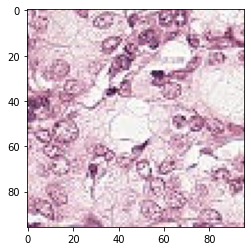

In [ ]:
# from research, these two images are noted as causing issues
# dd6dfed324f9fcb6f93f46f32fc800f2ec196be2
# 9369c7278ec8bcc6c880d99194de09fc2bd4efbe
img = mpimg.imread(f'{INPUT_TRAIN_PATH}/dd6dfed324f9fcb6f93f46f32fc800f2ec196be2.tif')
imgplot = plt.imshow(img)

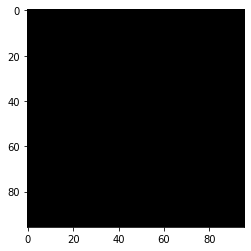

In [ ]:
img = mpimg.imread(f'{INPUT_TRAIN_PATH}/9369c7278ec8bcc6c880d99194de09fc2bd4efbe.tif')
imgplot = plt.imshow(img)

In [ ]:
# remove images noted above
data_df = data_df[data_df['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']
data_df = data_df[data_df['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

In [ ]:
print(data_df.shape)

(220023, 2)


In [ ]:
data_df['label'].value_counts()

0    130907
1     89116
Name: label, dtype: int64

In [ ]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=PurePath(IMAGE_PATH,sample.iloc[j]['id']).__str__() + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

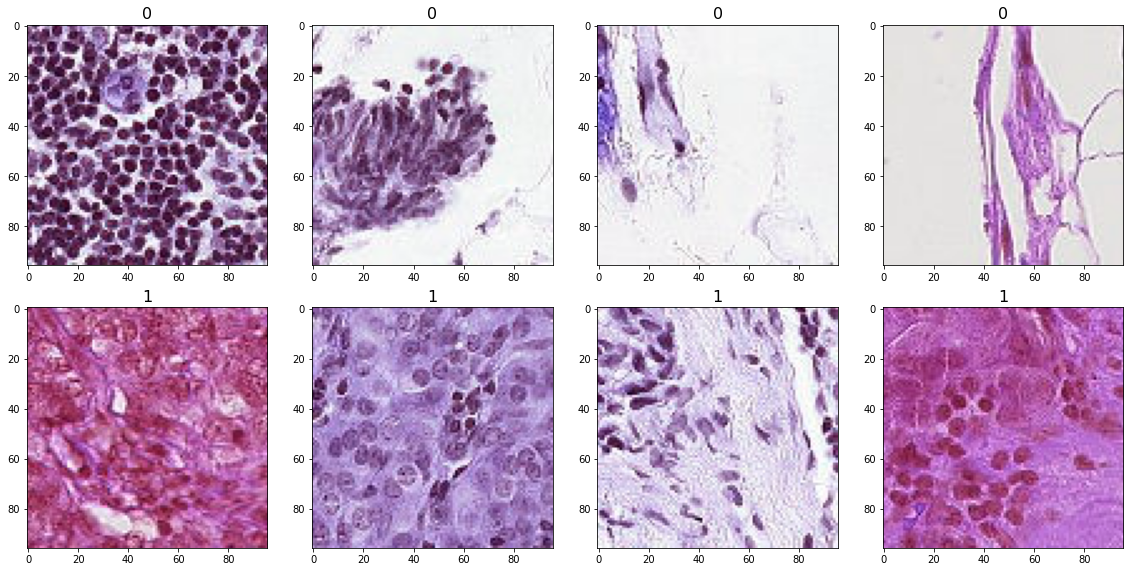

In [ ]:
draw_category_images('label',4, data_df, INPUT_TRAIN_PATH)

In [ ]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

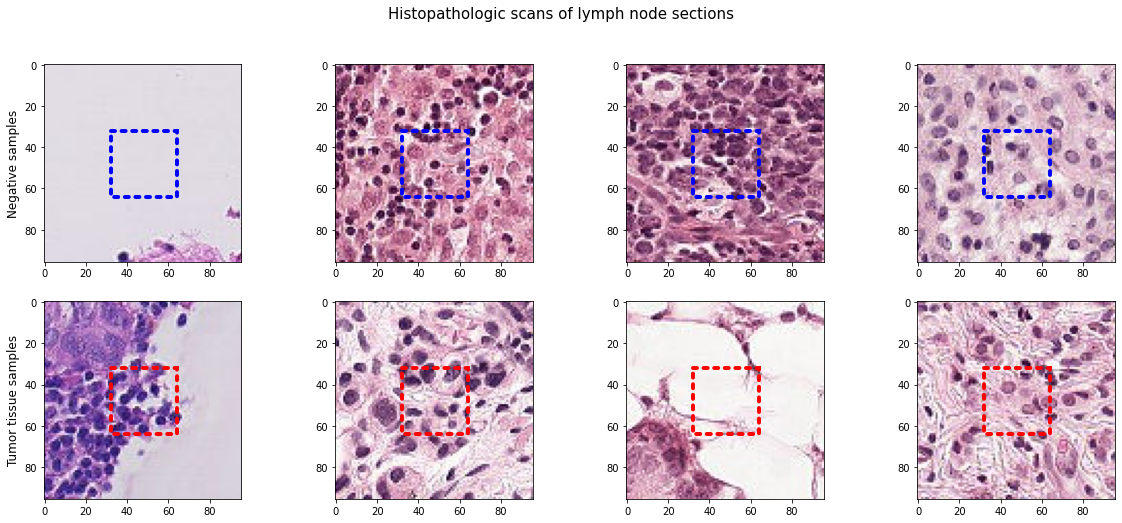

In [ ]:
# random sampling
shuffled = shuffle(data_df)

fig, ax = plt.subplots(2,4, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=15)

# Negatives
for i, idx in enumerate(shuffled[shuffled['label'] == 0]['id'][:4]):
    path = PurePath(INPUT_TRAIN_PATH,idx).__str__()
    ax[0,i].imshow(readImage(path + '.tif'))
    
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
    
ax[0,0].set_ylabel('Negative samples', size='large')

# Positives
for i, idx in enumerate(shuffled[shuffled['label'] == 1]['id'][:4]):
    path = PurePath(INPUT_TRAIN_PATH,idx).__str__()
    ax[1,i].imshow(readImage(path + '.tif'))
    
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
    
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

In [ ]:
SEED=101
SAMPLE_SIZE=75000
TEST_SIZE=0.15
IMAGE_SIZE=96

In [ ]:
# create sets
neg_df=data_df[data_df['label']==0].sample(SAMPLE_SIZE,random_state=SEED)
pos_df=data_df[data_df['label']==1].sample(SAMPLE_SIZE,random_state=SEED)

# concat dataframes
data_df = pd.concat([neg_df, pos_df], axis=0).reset_index(drop=True)

# shuffle the data
data_df = shuffle(data_df)

data_df['label'].value_counts()

1    75000
0    75000
Name: label, dtype: int64

In [ ]:
# do a train/test split
train_df, validation_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=SEED, stratify=data_df['label'])

In [ ]:
print(train_df.shape)
print(validation_df.shape)

(127500, 2)
(22500, 2)


In [ ]:
# create directories to organize train/validation sets
parent_paths = [TRAIN_PATH,VALIDATION_PATH]

for folder in parent_paths:
    for subfolder in ["0","1"]:
        new_path = PurePath(folder,subfolder)
        Path(new_path).mkdir(parents=True, exist_ok=True)

In [ ]:
def copy_images(image, label, image_set):
    # Build source path
    src = PurePath(INPUT_TRAIN_PATH,image).__str__() + '.tif'
    
    # Build dest path
    if image_set == 'train':
        dst = PurePath(TRAIN_PATH,str(label),image).__str__() + '.tif'
    elif image_set == 'validation':
        dst = PurePath(VALIDATION_PATH,str(label),image).__str__() + '.tif'
    
    # copy the files
    shutil.copyfile(src, dst)

In [ ]:
# copy the train images to the appropriate directory
train_df.apply(lambda x: copy_images(x["id"],x["label"],"train"), axis=1)

107899    None
132811    None
84391     None
71094     None
121982    None
          ... 
70440     None
46944     None
45115     None
145786    None
92474     None
Length: 127500, dtype: object

In [ ]:
# copy the train images to the appropriate directory
validation_df.apply(lambda x: copy_images(x["id"],x["label"],"validation"), axis=1)

20002     None
7123      None
108361    None
76132     None
132862    None
          ... 
132452    None
133545    None
144642    None
30486     None
124802    None
Length: 22500, dtype: object

In [ ]:
IMAGE_SIZE = 96
num_train_samples = len(train_df)
num_val_samples = len(validation_df)
train_batch_size = 32
val_batch_size = 32

# Create data generators
datagen  = ImageDataGenerator(rescale=1.0/255.0,
                                  vertical_flip = True,
                                  horizontal_flip = True)

# we won't do augmentation on validation data
test_datagen = ImageDataGenerator(rescale=1.0/255.0)


train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = test_datagen.flow_from_directory(VALIDATION_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = test_datagen.flow_from_directory(VALIDATION_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

train_steps=train_gen.n//train_gen.batch_size
val_steps=val_gen.n//val_gen.batch_size
#STEP_SIZE_TEST=test_gen.n//test_gen.batch_size

Found 127500 images belonging to 2 classes.
Found 22500 images belonging to 2 classes.
Found 22500 images belonging to 2 classes.


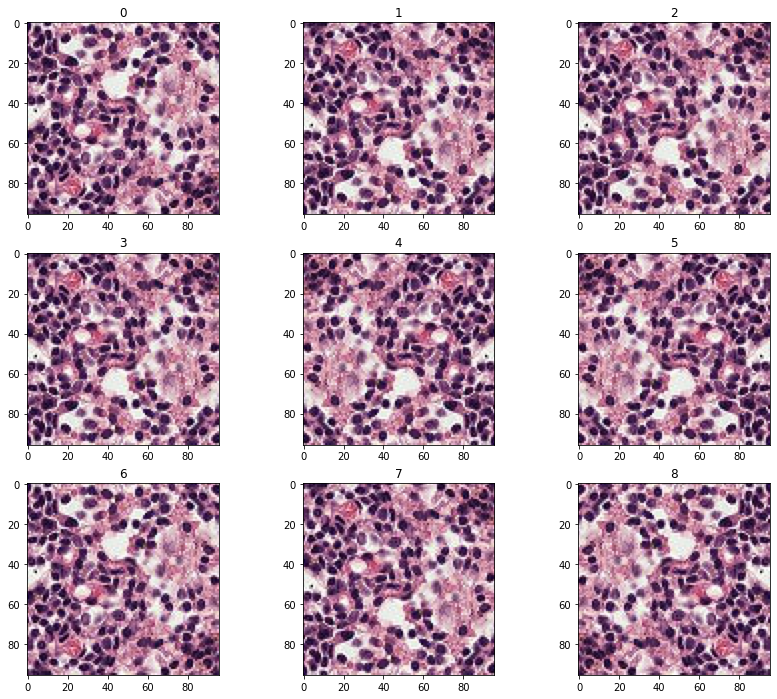

In [ ]:
# Example of image generation
count = 8

# grab an image and conver it to an np array
imgs = os.listdir(INPUT_TRAIN_PATH)[:1]
image = img_to_array(load_img(f'{INPUT_TRAIN_PATH}/'+imgs[0]))
image = image.reshape((1,) + image.shape)

# set up some plot stuff
fig = plt.figure(figsize=(14, 12))
fig.subplots_adjust()

# Create a flow of images based on my image
images_flow = datagen.flow(image, batch_size=1)

# loop through image flow
for i, new_images in enumerate(images_flow):
    
    # Grab just the first, since batch size is 1
    new_image = array_to_img(new_images[0], scale=True)
    
    # add a subplot, and add image
    ax = fig.add_subplot(3,3, i + 1)
    ax.imshow(new_image)
    ax.set_title(i)

    # break when our counter is reached
    if i >= count:
        break

In [ ]:
kernel_size = (3,3)
pool_size= (2,2)

#base_filters = 16
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

model = Sequential()
# (CONV => RELU => POOL) * 2
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

# (CONV => RELU => POOL) * 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# (CONV => RELU => POOL) * 2
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

# sigmoid classifier
model.add(Dense(1, activation = "sigmoid"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization (BatchNo (None, 92, 92, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 44, 44, 64)       

In [ ]:
model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

In [ ]:
earlystopper = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

history = model.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=13,
                    use_multiprocessing=True,
                   workers=16,
                   max_queue_size=32,
                   callbacks=[reducel, earlystopper])

Epoch 1/13
3984/3984 [==============================] - 79s 20ms/step - loss: 0.3278 - accuracy: 0.8634 - val_loss: 0.7154 - val_accuracy: 0.6322
Epoch 2/13
3984/3984 [==============================] - 80s 20ms/step - loss: 0.3001 - accuracy: 0.8793 - val_loss: 0.4343 - val_accuracy: 0.8141
Epoch 3/13
3984/3984 [==============================] - 79s 20ms/step - loss: 0.2814 - accuracy: 0.8884 - val_loss: 0.6150 - val_accuracy: 0.7379

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 4/13
3984/3984 [==============================] - 80s 20ms/step - loss: 0.2357 - accuracy: 0.9083 - val_loss: 0.2269 - val_accuracy: 0.9078
Epoch 5/13
3984/3984 [==============================] - 80s 20ms/step - loss: 0.2246 - accuracy: 0.9138 - val_loss: 0.2050 - val_accuracy: 0.9161
Epoch 6/13
3984/3984 [==============================] - 80s 20ms/step - loss: 0.2207 - accuracy: 0.9153 - val_loss: 0.4732 - val_accuracy: 0.8171

Epoch 00006: ReduceLROnPlateau reducing le

In [ ]:
val_loss, val_acc = \
model.evaluate(test_gen, 
                        steps=len(validation_df))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

22500/22500 [==============================] - 48s 2ms/step - loss: 0.1855 - accuracy: 0.9265
val_loss: 0.1855384260416031
val_acc: 0.9265333414077759


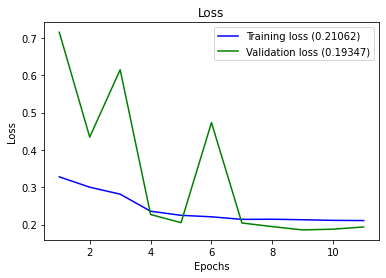

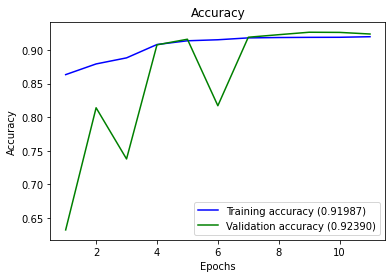

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_history(history)

In [ ]:
y_pred_keras = model.predict(test_gen, steps=len(validation_df), verbose=1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

22500/22500 [==============================] - 34s 2ms/step


0.9803382953086419

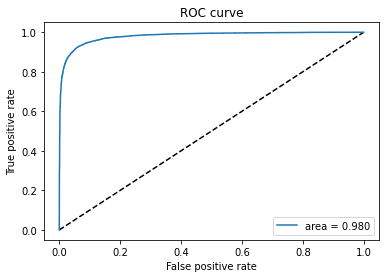

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
print(TEST_IMAGE_PATH)
Path(TEST_IMAGE_PATH).mkdir(parents=True, exist_ok=True)

# Make test path and copy images to test set path
for f in os.listdir(INPUT_TEST_PATH):
  shutil.copy(PurePath(INPUT_TEST_PATH,f), PurePath(TEST_IMAGE_PATH,f))

print('done!')

test/images
done!


In [ ]:
# Build a test generator
test_gen = test_datagen.flow_from_directory(TEST_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [ ]:
model.predict_generator(test_gen, steps=num_test_images, verbose=1)

1/1 [==============================] - 0s 30ms/step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


array([[0.99986887]], dtype=float32)

In [ ]:
# Run model against test images
num_test_images = len(os.listdir(TEST_IMAGE_PATH))

predictions = model.predict(test_gen, steps=num_test_images, verbose=1)
prediction_df = pd.DataFrame(predictions)

prediction_df.head()
# This outputs the file names in the sequence in which 
# the generator processed the test images.
test_filenames = test_gen.filenames

# add the filenames to the dataframe
prediction_df['file_names'] = test_filenames

prediction_df.head()
def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

prediction_df['id'] = prediction_df['file_names'].apply(extract_id)

prediction_df.head()

57458/57458 [==============================] - 90s 2ms/step


,0,file_names,id
0,0.999869,images/00006537328c33e284c973d7b39d340809f7271...,00006537328c33e284c973d7b39d340809f7271b
1,0.819788,images/0000ec92553fda4ce39889f9226ace43cae3364...,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.975062,images/00024a6dee61f12f7856b0fc6be20bc7a48ba3d...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.063447,images/000253dfaa0be9d0d100283b22284ab2f6b643f...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.009745,images/000270442cc15af719583a8172c87cd2bd9c774...,000270442cc15af719583a8172c87cd2bd9c7746
